In [3]:
from qiskit.circuit import QuantumCircuit
qc = QuantumCircuit(4)
qc.h(0)
qc.cx(0, 1)
qc.x(2)
qc.cx(2, 3)
qc.measure_all()
print(qc.num_qubits)

print(qc)

4
        ┌───┐      ░ ┌─┐         
   q_0: ┤ H ├──■───░─┤M├─────────
        └───┘┌─┴─┐ ░ └╥┘┌─┐      
   q_1: ─────┤ X ├─░──╫─┤M├──────
        ┌───┐└───┘ ░  ║ └╥┘┌─┐   
   q_2: ┤ X ├──■───░──╫──╫─┤M├───
        └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ─────┤ X ├─░──╫──╫──╫─┤M├
             └───┘ ░  ║  ║  ║ └╥┘
meas: 4/══════════════╩══╩══╩══╩═
                      0  1  2  3 


--- Sequential BV (measure-at-end) ---


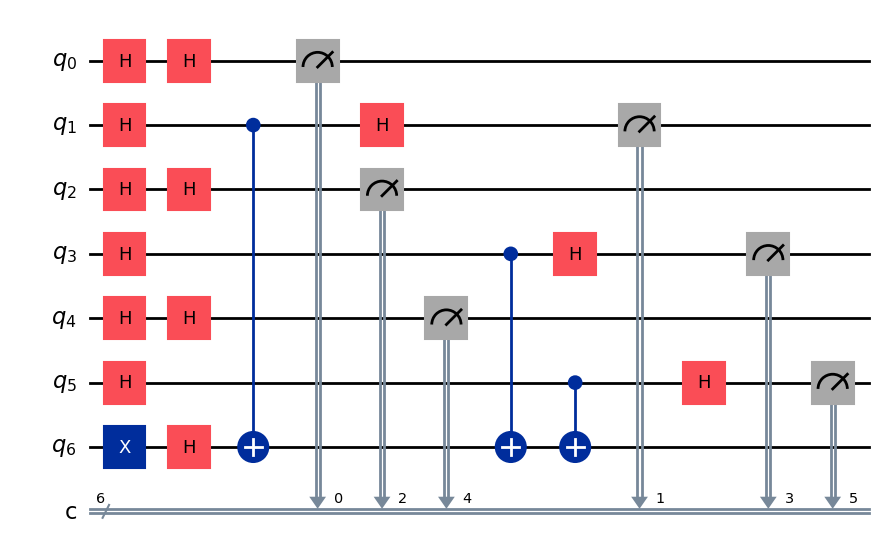

In [4]:
#BV:
s = '101010'
n = len(s)
qc_seq = QuantumCircuit(n + 1, n)

# Ancilla prep
qc_seq.x(n)
qc_seq.h(n)
for i in range(n):
    qc_seq.h(i)
    if s[n - 1 - i] == '1':
        qc_seq.cx(i, n)
    qc_seq.h(i)

for i in range(n):
    qc_seq.measure(i, i)

print("--- Sequential BV (measure-at-end) ---")
display(qc_seq.draw('mpl'))

In [5]:
from qiskit.converters import circuit_to_dag
import numpy as np

#one_beat is assumed to be all other gates
two_beat_gates = ['cx'] #we assume that the circuits are small enough that cnots do not require too much overhead
three_beat_gates = ['h']

def get_logical_circuit_time(qc: QuantumCircuit):
    """
    # TODO UPDATE THIS FUNCTION TO USE THE DAG SO DIFFERENT LENGTH OPS CAN STILL BE RAN AT THE SAME TIME
    
    we model the temporal circuit depth adhering to Table I from Kobori et al.'s LSQCA with 0s replaced with 1s

    we ignore preparation time at the beginning of the circuit, 
    but not after reset operations
    """
    dag = circuit_to_dag(qc)
    circuit_depth = 0
    for depth, layer in enumerate(dag.layers()):
        longest_time_op = 1
        
        for node in layer["graph"].op_nodes():
            #assume that a barrier cannot be at the same time as any other operation
            if node.name == 'barrier':
                longest_time_op = 0
                break
            elif node.name in two_beat_gates:
                longest_time_op = max(2, longest_time_op)
            elif node.name in three_beat_gates:
                longest_time_op = max(3, longest_time_op)

        circuit_depth += longest_time_op
    return circuit_depth

In [6]:
get_logical_circuit_time(qc)

6

In [7]:


def get_average_lifetimes(qc: QuantumCircuit):
    dag = circuit_to_dag(qc)
    all_lifetimes = []
    dynamic_lifetimes = [0] * qc.num_qubits
    measured_qubits = []

    for depth, layer in enumerate(dag.layers()):
        longest_time_op = 1
        
        for node in layer["graph"].op_nodes():
            #assume that a barrier cannot be at the same time as any other operation
            if node.name == 'barrier':
                longest_time_op = 0
                break
            elif node.name in two_beat_gates:
                longest_time_op = max(2, longest_time_op)
            elif node.name in three_beat_gates:
                longest_time_op = max(3, longest_time_op)

            if node.name == 'measure':
                for q in node.qargs:
                    index = qc.qubits.index(q)
                    #fixes the qubit lifetime so it will not be incremented later, unless there is a reset
                    measured_qubits.append(index)
                    dynamic_lifetimes[index] += 1 #measurement takes 1 time unit

            if node.name == 'reset':
                for q in node.qargs:
                    index = qc.qubits.index(q)
                    all_lifetimes.append(dynamic_lifetimes[index])
                    dynamic_lifetimes[index] = 0
                    try:
                        measured_qubits.remove(index)
                    except:
                        ValueError()
        for i in range(qc.num_qubits):
            #only increment non-measured qubits, as measured ones no longer count as living
            if i not in measured_qubits:
                dynamic_lifetimes[i] += longest_time_op
        
    all_lifetimes += list(filter(lambda x: x != 0, dynamic_lifetimes))
    return {'avg_lifetime': np.mean(all_lifetimes), 'max_lifetime': np.max(all_lifetimes), 'lifetimes': all_lifetimes}

In [8]:
get_average_lifetimes(qc_seq)

{'avg_lifetime': 12.0,
 'max_lifetime': 18,
 'lifetimes': [7, 12, 7, 15, 7, 18, 18]}

In [9]:
def get_decoherence_fidelities(lifetimes, distance: int):
    fidelities = []
    T1 = 20000 #T1 time in SC is ~200µs and single qubit gate is ~10ns
    #https://www.spinquanta.com/news-detail/ultimate-guide-to-coherence-time
    #https://postquantum.com/quantum-modalities/superconducting-qubits
    max_e_phys = 0.1 #derived from formula in Camps, Rrapaj, Klymko et al.
    
    for lifetime in lifetimes:
        #formula from Camps, Rrapaj, Klymko et al. 
        #Quantum Computing Technology Roadmaps and Capability Assessment for Scientific
        #Computing - An analysis of use cases from the NERSC workload
        e_phys = min(max_e_phys, 1-np.exp(-lifetime/T1))
        f_log = 1 - 0.1 * ((100*(e_phys))**((distance+1)/2))
        #maximum logical error should not surpass maximum physical error
        fidelities.append(max(f_log, 1-max_e_phys))

    print("decoherence fidelities for each qubit life:\n", fidelities)
    return fidelities

def get_total_decoherence_fidelity(fidelities: list):
    total_fidelity = 1
    for f in fidelities:
        total_fidelity *= f
    return total_fidelity

distance = 3 #MAKE SURE YOU CHANGE THIS
data = get_average_lifetimes(qc_seq)
decoherence_fidelities = get_decoherence_fidelities(data.get('lifetimes'), distance=distance)
total_decoherence_fidelity = get_total_decoherence_fidelity(decoherence_fidelities)
print("total fidelity due to decoherence: ", total_decoherence_fidelity)
    

decoherence fidelities for each qubit life:
 [0.9998775428662476, 0.9996402159244194, 0.9998775428662476, 0.9994379216904891, 0.9998775428662476, 0.9991907286174226, 0.9991907286174226]
total fidelity due to decoherence:  0.9970955490190019


In [10]:
#testing logical vs physical error formula
lifetime = 100
T1 = 100000
distance = 3
e_p = min(0.1, 1-np.exp(-lifetime/T1))
print(e_p)

f_l = 1 - 0.1 * ((100*(e_p))**((distance+1)/2))
print(f_l)

0.000999500166624978
0.9990009994169167


In [12]:
data = get_average_lifetimes(qc_seq)
decoherence_fidelities = get_decoherence_fidelities(data.get('lifetimes'), distance=3)
total_fidelity = 1
for f in decoherence_fidelities:
    total_fidelity *= f
print("total fidelity: ", f)

decoherence fidelities for each qubit life:
 [0.9998775428662476, 0.9996402159244194, 0.9998775428662476, 0.9994379216904891, 0.9998775428662476, 0.9991907286174226, 0.9991907286174226]
total fidelity:  0.9991907286174226


In [21]:
def get_idle_times(qc: QuantumCircuit):
    dag = circuit_to_dag(qc)
    all_lifetimes = [] #all idle times
    dynamic_lifetimes = [0] * qc.num_qubits #current idle times
    measured_qubits = []

    for depth, layer in enumerate(dag.layers()):
        longest_time_op = 1
        used_qubits = [] #indices of qubits that undergo operations during the layer
        for node in layer["graph"].op_nodes():
            #assume that a barrier cannot be at the same time as any other operation
            if node.name == 'barrier':
                longest_time_op = 0
                break
            elif node.name in two_beat_gates:
                longest_time_op = max(2, longest_time_op)
            elif node.name in three_beat_gates:
                longest_time_op = max(3, longest_time_op)

            for q in node.qargs:
                index = qc.qubits.index(q)
                if index not in used_qubits:
                    used_qubits.append(index)
        
        for node in layer["graph"].op_nodes():
            if node.name == 'barrier':
                longest_time_op = 0
                break

            if node.name == 'measure':
                for q in node.qargs:
                    index = qc.qubits.index(q)
                    all_lifetimes.append(dynamic_lifetimes[index])
                    dynamic_lifetimes[index] = 0
                    #fixes the qubit lifetime so it will not be incremented later, unless there is a reset
                    measured_qubits.append(index)
            elif node.name == 'reset':
                for q in node.qargs:
                    index = qc.qubits.index(q)
                    if index in measured_qubits:
                        measured_qubits.remove(index)
            
            # we should still do this for a reset gate:
            if node.name != 'measure':
                node_time = 3 if node.name in three_beat_gates else 2 if node.name in two_beat_gates else 1
                for q in node.qargs:
                    index = qc.qubits.index(q)
                    dynamic_lifetimes[index] += longest_time_op - node_time
        
        # add idling noise to all qubits not operated on in the layer
        for i in range(qc.num_qubits):
            if i not in used_qubits and i not in measured_qubits:
                dynamic_lifetimes[i] += longest_time_op
        
    all_lifetimes += list(filter(lambda x: x != 0, dynamic_lifetimes))
    return {'idle_times': all_lifetimes}

In [22]:
print(get_idle_times(qc))

{'idle_times': [0, 3, 2, 3]}
